## Data Loading ##

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import MobileNetV2

Mount Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defineing Paths

In [ ]:
dataset_dir = "/content/drive/My Drive/cyfuture"

In [ ]:
def load_image_paths_and_labels(dataset_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))  #
    print("Classes:", class_names)

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                image_paths.append(img_path)
                labels.append(label)

    return image_paths, labels, class_names

segmentation

In [ ]:
def img_segmentation(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)

    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)

    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)

    return final_result

preprocessing

In [ ]:
def preprocess_image(img_path, img_size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.numpy_function(img_segmentation, [img], tf.uint8)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

splitting the data

In [ ]:
image_paths, labels, class_names = load_image_paths_and_labels(dataset_dir)
num_classes = len(class_names)
labels = to_categorical(labels, num_classes)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=1/3, stratify=temp_labels, random_state=42
)


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


TensorFlow Data

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(50).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(50).prefetch(tf.data.AUTOTUNE)


## MODEL ##

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)

In [ ]:
joblib.dump(model, '/content/drive/My Drive/leaf_disease_model.pkl')

Training Model

In [ ]:
# Evaluate on training dataset
train_loss, train_acc = model.evaluate(train_dataset)
print(f"Training Accuracy: {train_acc:.4f}")

# Evaluate on validation dataset
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9928 - loss: 0.0440
Training Accuracy: 0.9923
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9791 - loss: 0.0714
Validation Accuracy: 0.9779


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions for validation data
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Predict
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 645ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Classification Report:
                          precision    recall  f1-score   support

      Apple___Apple_scab       0.93      0.98      0.95       126
       Apple___Black_rot       0.98      0.98      0.98       124
Apple___Cedar_apple_rust       1.00      1.00      1.00        55
         Apple___healthy       0.99      0.98      0.98       329

                accuracy                           0.98       634
               macro avg       0.98      0.98      0.98       634
            wei

In [8]:
!pip install transformers

In [ ]:
from transformers import pipeline

In [ ]:
llm = pipeline("text-generation",model="gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


##Runnig Model With Out Ui##

Saving 2a97b29d-8a63-47ab-bd5b-c14832a586c8___FREC_Scab 3242.JPG to 2a97b29d-8a63-47ab-bd5b-c14832a586c8___FREC_Scab 3242.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Apple Scab


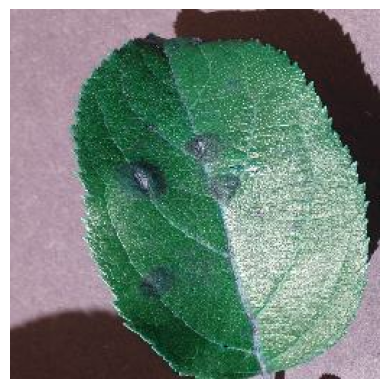


Disease Information:
Cause: Fungal infection caused by Venturia inaequalis.
Precautions: Prune infected leaves, apply fungicides, use disease-resistant varieties.
Crop Management: Remove fallen leaves, ensure proper spacing for air circulation.
Fertilizers: Use balanced fertilizers with potassium and phosphorus.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Chatbot: not so sure so far no as


KeyboardInterrupt: Interrupted by user

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from transformers import pipeline  # Pretrained LLM from Hugging Face
from huggingface_hub import login
import os


model_save_path = "/content/drive/My Drive/leaf_disease_model.h5"
model = tf.keras.models.load_model(model_save_path)

# Define class labels
class_labels = ["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"]

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get file name

# Function to preprocess the image
def preprocess_image(img_path, img_size=(224, 224)):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

input_image = preprocess_image(image_path)
input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get predicted disease name
predicted_disease = class_labels[predicted_class]
print(f"Prediction: {predicted_disease}")

# Display the image
plt.imshow(cv2.imread(image_path))
plt.axis("off")
plt.show()

# Disease Information
disease_info = {
    "Apple Scab": {
        "Cause": "Fungal infection caused by Venturia inaequalis.",
        "Precautions": "Prune infected leaves, apply fungicides, use disease-resistant varieties.",
        "Crop Management": "Remove fallen leaves, ensure proper spacing for air circulation.",
        "Fertilizers": "Use balanced fertilizers with potassium and phosphorus."
    },
    "Black Rot": {
        "Cause": "Fungus Botryosphaeria obtusa.",
        "Precautions": "Remove infected fruits, apply copper-based fungicides.",
        "Crop Management": "Avoid overhead watering, maintain soil health.",
        "Fertilizers": "Use nitrogen-based fertilizers in moderate amounts."
    },
    "Cedar Apple Rust": {
        "Cause": "Fungus Gymnosporangium juniperi-virginianae.",
        "Precautions": "Remove nearby cedar trees, apply fungicides during spring.",
        "Crop Management": "Use resistant apple varieties, prune infected branches.",
        "Fertilizers": "Apply organic compost and balanced NPK fertilizers."
    },
    "Healthy": {
        "Message": "No disease detected! Maintain good agricultural practices."
    }
}

# Display Disease Info
if predicted_disease != "Healthy":
    info = disease_info[predicted_disease]
    print("\nDisease Information:")
    print(f"Cause: {info['Cause']}")
    print(f"Precautions: {info['Precautions']}")
    print(f"Crop Management: {info['Crop Management']}")
    print(f"Fertilizers: {info['Fertilizers']}")
else:
    print(disease_info["Healthy"]["Message"])


def chatbot_response(user_input, disease):
    context = f"The detected disease is {disease}. {disease_info[disease]}. Answer the user query about this plant disease."
    prompt = f"{context}\nUser: {user_input}\nChatbot:"

    response = llm(prompt, max_length=200, num_return_sequences=1)
    return response[0]["generated_text"].split("Chatbot:")[-1].strip()

# Interactive Chatbot
while True:
    user_query = input("\nAsk about the disease (or type 'exit' to stop): ")
    if user_query.lower() == "exit":
        break
    response = chatbot_response(user_query, predicted_disease)
    print("\nChatbot:", response)

##GPT-2 Model##

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import wandb
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)
dataset = load_dataset("json", data_files="custom_data.jsonl", split="train")
def tokenize_function(examples):
    combined_texts = [f"{question}\n{answer}" for question, answer in zip(examples["question"], examples["answer"])]
    tokenized = tokenizer(combined_texts, truncation=True, max_length=512, padding="max_length")
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized
tokenized_dataset = dataset.map(tokenize_function, batched=True)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir="./logs",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset
)
trainer.train()
model_save_path = "/content/drive/My Drive/gpt2_apple_disease_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")


##Running Model with Streamlit##

In [ ]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import joblib
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as pi
from transformers import AutoModelForCausalLM, AutoTokenizer

model_path = "/content/drive/My Drive/gpt2_apple_disease_model"
gpt_model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Class labels and disease info
class_labels = ["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"]
disease_info = {
    "Apple Scab": {
        "Cause": "Fungal infection caused by Venturia inaequalis.",
        "Precautions": "Prune infected leaves, apply fungicides, use disease-resistant varieties.",
        "Crop Management": "Remove fallen leaves, ensure proper spacing for air circulation.",
        "Fertilizers": "Use balanced fertilizers with potassium and phosphorus."
    },
    "Black Rot": {
        "Cause": "Fungus Botryosphaeria obtusa.",
        "Precautions": "Remove infected fruits, apply copper-based fungicides.",
        "Crop Management": "Avoid overhead watering, maintain soil health.",
        "Fertilizers": "Use nitrogen-based fertilizers in moderate amounts."
    },
    "Cedar Apple Rust": {
        "Cause": "Fungus Gymnosporangium juniperi-virginianae.",
        "Precautions": "Remove nearby cedar trees, apply fungicides during spring.",
        "Crop Management": "Use resistant apple varieties, prune infected branches.",
        "Fertilizers": "Apply organic compost and balanced NPK fertilizers."
    },
    "Healthy": {
        "Message": "No disease detected! Maintain good agricultural practices."
    }
}

# Function to generate chatbot response
def chatbot_response(query, disease):
    context = f"The detected disease is {disease}. {disease_info.get(disease, {}).get('Cause', 'No information available')}"
    prompt = f"{context}\nUser: {query}\nChatbot:"
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = gpt2_model.generate(inputs, max_length=150, do_sample=True, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("Chatbot:")[-1].strip()

st.title("🌿 Plant Disease Detection & Chatbot 🤖")
st.write("Upload a leaf image to detect disease and chat about its management.")

with st.spinner("Loading Model Into Memory...."):
    model_save_path = "leaf_disease_model.pkl"
    model = joblib.load(model_save_path)

uploaded_image = st.file_uploader(label="Upload Image", type=["png", "jpg", "jpeg"])

if uploaded_image is not None:
    img_bytes = np.asarray(bytearray(uploaded_image.read()), dtype=np.uint8)
    img = cv2.imdecode(img_bytes, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img, (224, 224))
    st.image(img, channels="RGB")
    img_resize = pi(img_resize)
    img_reshape = img_resize[np.newaxis, ...]

    predict_img = st.button("Predict")

    if predict_img:
        predictions = model.predict(img_reshape)
        predicted_class = np.argmax(predictions, axis=1)[0]
        disease_name = class_labels[predicted_class]

        st.title(f"Prediction: {disease_name}")
        for key, value in disease_info[disease_name].items():
            st.write(f"**{key}:** {value}")

        user_query = st.text_input("Ask me anything about the disease")

        if user_query:
            response = chatbot_response(user_query, disease_name)
            st.write("🤖 Chatbot Response:", response)

if __name__ == "__main__":
    st.write("### Ready to Detect and Assist!")


In [10]:
!curl https://loca.lt/mytunnelpassword

34.87.125.144

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.125.144:8501

⠸⠼⠴your url is: https://blue-wolves-march.loca.lt
2025-02-16 14:28:50.518435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739716130.553831   10679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739716130.562596   10679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 14:28:54.836389: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value 